Can we use the database to create the model that would maximize the consumer report rating? What does that model look like and how accurate the model is?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
df = pd.read_csv("cereal.csv")
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


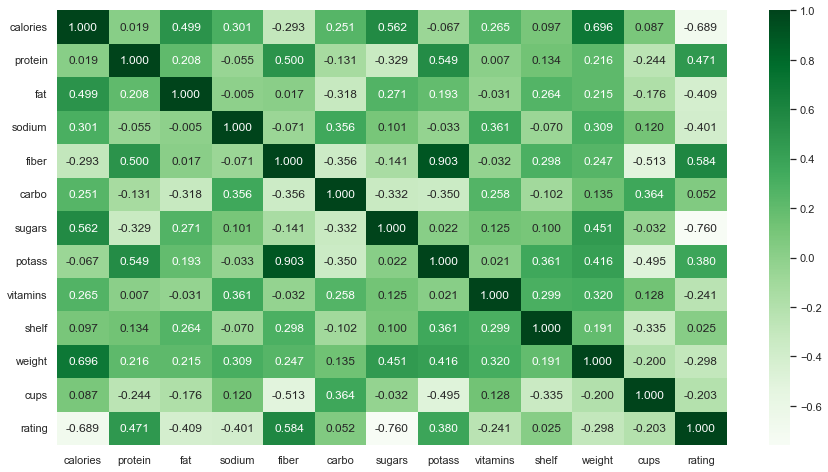

In [2]:
sns.set(rc = {'figure.figsize':(15,8)})
fig1=sns.heatmap(df.corr(), annot=True, fmt=".3f",cmap='Greens');

In [14]:
# Consider only numerical variables
num_vars = df[['calories','protein','sugars', 'fiber', 'potass']]
y = df['rating']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test)

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.8126818400105158 on 24 values.'

In [15]:
preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']
preds_vs_act.head()

,actual,preds,diff
0,34.384843,41.038871,-6.654028
1,21.871292,30.710181,-8.838889
2,18.042851,26.023417,-7.980566
3,68.402973,71.207312,-2.804339
4,34.139765,30.352921,3.786844


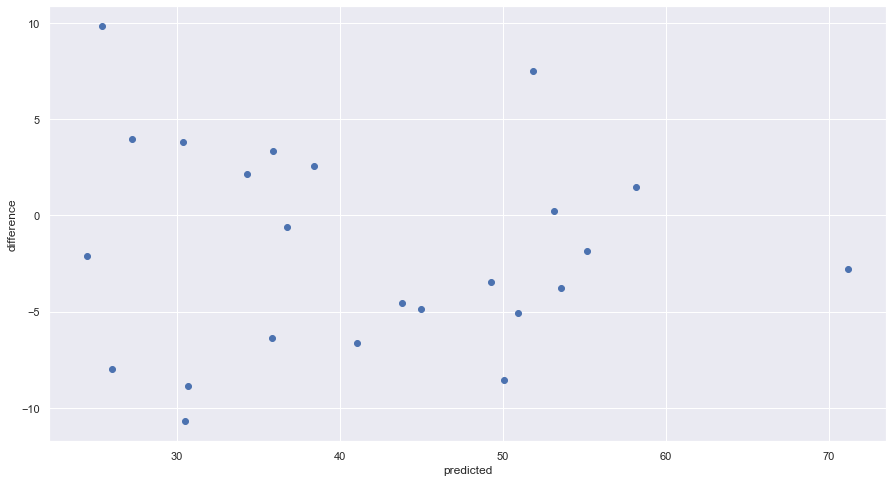

In [20]:
plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

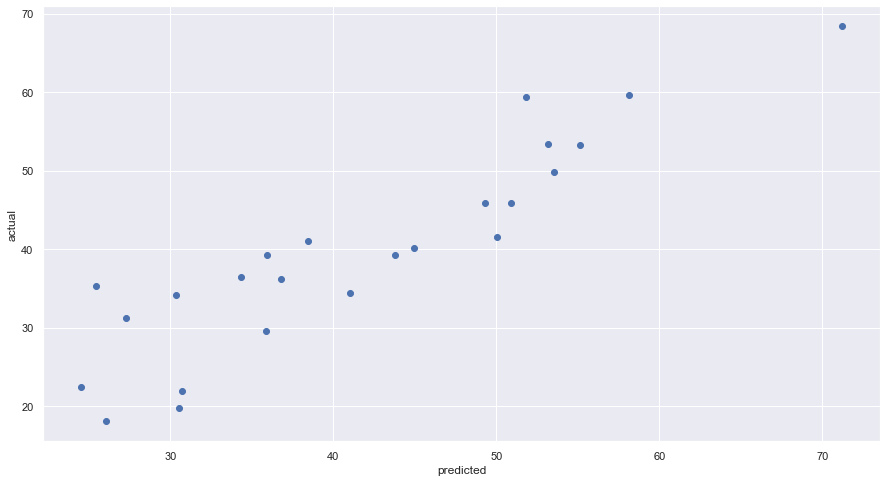

In [21]:
plt.plot(preds_vs_act['preds'], preds_vs_act['actual'], 'bo');
plt.xlabel('predicted');
plt.ylabel('actual'); #This looks less compelling that we are predicting well...
# I also think I found the mean amount...which aren't real 'actual' salaries

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True, param_grid=None):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        if param_grid==None:
            rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

        else:
            rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
            rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1)

        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    if param_grid==None:
        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

    else:
        rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
        rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

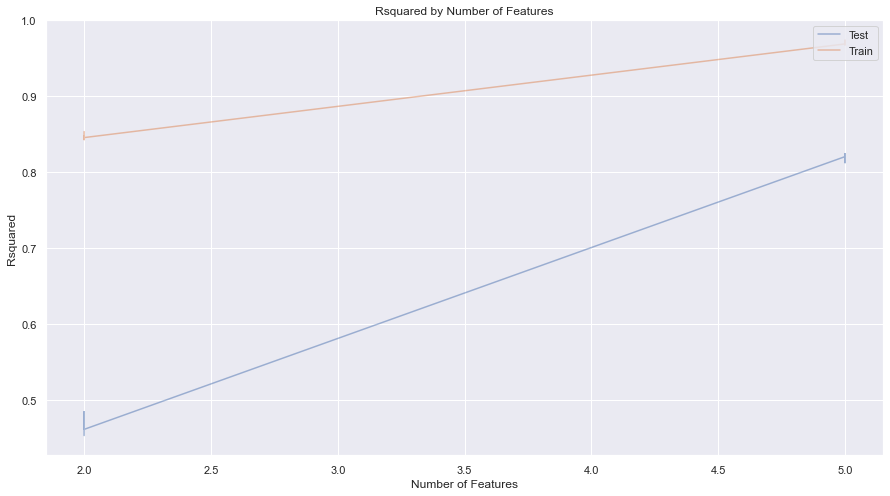

In [29]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs)

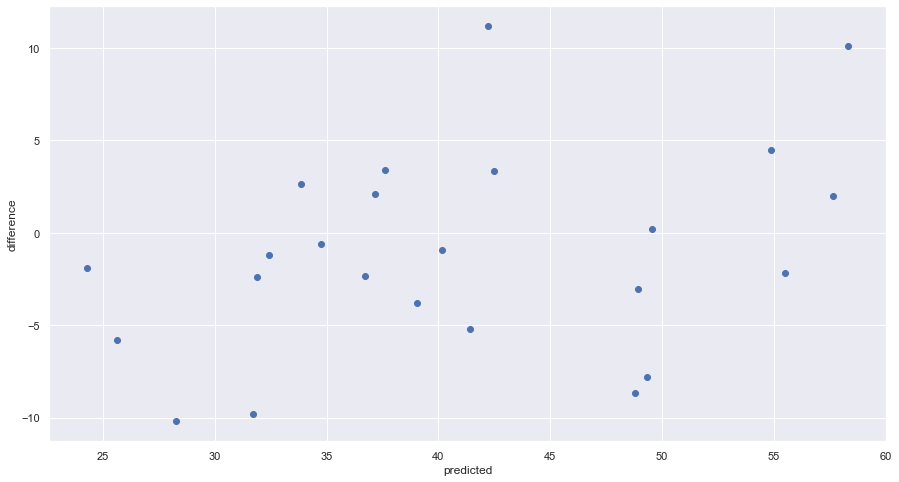

In [30]:
y_test_preds = rf_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

In [31]:
from sklearn.model_selection import GridSearchCV

### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True, param_grid=None):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        if param_grid==None:
            rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

        else:
            rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
            rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1)

        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    if param_grid==None:
        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

    else:
        rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
        rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 co

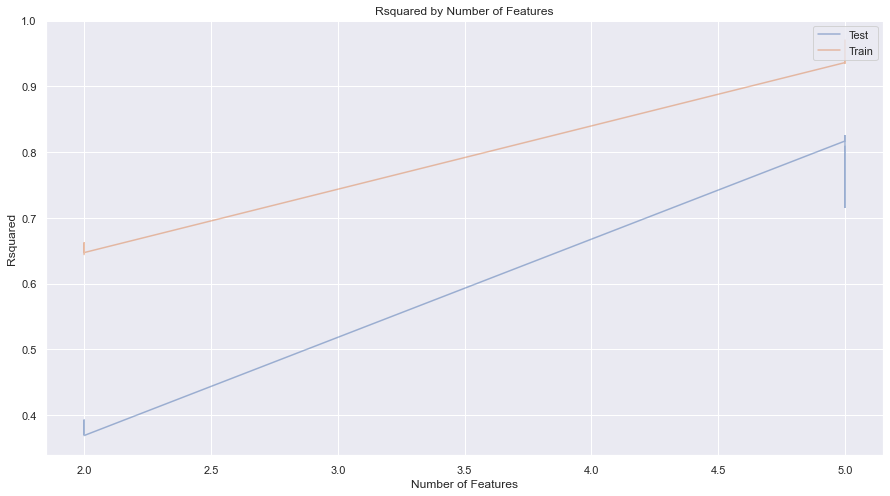

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
params = {'n_estimators': [10, 100, 1000], 'max_depth': [1, 5, 10, 100]}
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs, param_grid=params)